# Welcome to my MNIST-Project

## Data

In [8]:
import numpy as np
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pickle
import random
from PIL import Image
import torchvision

Downlaod the Datasets from "https://github.com/phoebetronic/mnist"

In [9]:
# Attention! Not the actual name; Actual names are 'train_list' & 'train_list'
train_file = "data/mnist_train.csv"
test_file = "data/mnist_test.csv"

# Counting the Dataset
train_file = open(train_file, "r")
train_list = train_file.readlines()
train_file.close()
print(f"Trainset has {len(train_list)} Images")

test_file = open(test_file, "r")
test_list = test_file.readlines()
test_file.close()
print(f"Testset has {len(test_list)} Images")

Trainset has 60000 Images
Testset has 10000 Images


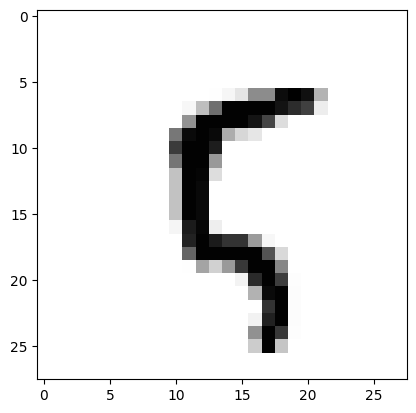

In [10]:
values = train_list[100].split(",")
image_array = np.asarray(values[1:], dtype=np.float32).reshape((28,28))
plt.imshow(image_array, cmap="Greys", interpolation="None")

## Neuronal Network



In [11]:
class DenseNeuronalNetwork:
    def __init__(self, sizes):
        self.sizes = sizes

        input_layer = sizes[0]
        hidden_layer_1 = sizes[1]
        hidden_layer_2= sizes[2]
        output_layer = sizes[3]

        self.params = {
            'weight1': torch.randn(hidden_layer_1, input_layer, device=device) * (1 / hidden_layer_1) ** 0.5,
            'weight2': torch.randn(hidden_layer_2, hidden_layer_1, device=device) * (1 / hidden_layer_2) ** 0.5,
            'weight3': torch.randn(output_layer, hidden_layer_2, device=device) * (1 / output_layer) ** 0.5
        }

    def sigmoid(self, x, derivatative=False):
        sig = 1/(1 + torch.exp(-x))

        if derivatative:
            return(sig * (1-sig))
        return(sig)

    def forward_pass(self, x_train):
        params = self.params

        A0 = x_train.to(device)
        params['A0'] = A0

        # Input Layer to Hidden Layer 1
        Z1 = params['weight1'] @ A0
        A1 = self.sigmoid(Z1)
        params['Z1'], params['A1'] = Z1, A1

        # Hidden layer 1 to Hidden Layer 2
        Z2 = params['weight2'] @ A1
        A2 = self.sigmoid(Z2)
        params['Z2'], params['A2'] = Z2, A2

        # Hidden Layer 2 to Output Layer
        Z3 = params['weight3'] @ A2
        A3= self.sigmoid(Z3)
        params['Z3'], params['A3'] = Z3, A3

        return params['A3']

    def backward_pass(self, y_train, output):
        params = self.params

        change_weight = {}

        batch_size = y_train.shape[1]

        # Calculate the weight3 Update
        error = output - y_train
        change_weight['weight3'] = (error @ params['A2'].T) / batch_size

        # Calculate the weight2 Update
        error  = params['weight3'].T @ error * self.sigmoid(params['Z2'], derivatative=True)
        change_weight['weight2'] = (error @ params['A1'].T) / batch_size

         # Calculate the weight1 Update
        error  = params['weight2'].T @ error * self.sigmoid(params['Z1'], derivatative=True)
        change_weight['weight1'] = (error @ params['A0'].T) / batch_size

        return change_weight

    def update_weights(self, change_weight, learningRate):
        for key, val in change_weight.items():
            self.params[key] -= learningRate * val

    def accuracy(self, test_data):
        predictions = []
        for x in test_data:
            values = x.split(",")
            inputs = torch.tensor((np.asarray(values[1:], dtype=np.float32) / 255.0 * 0.99) + 0.01, dtype=torch.float32, device=device).view(-1, 1)
            targets = torch.zeros(10, device=device) + 0.01
            targets[int(values[0])] = 0.99
            output = self.forward_pass(inputs)
            prediction = torch.argmax(output).item()
            predictions.append(prediction == torch.argmax(targets).item())

        return torch.tensor(predictions, dtype=torch.float32).mean().item()
            

    def train(self, train_list, test_list, epochs, learningRate ,batch_size=32):
        for i in range(epochs):
            start_time = time.time()
            random.shuffle(train_list)
 
            for b in range(0, len(train_list), batch_size):
                batch = train_list[b:b+batch_size]
 
                inputs, targets = [], []
                for x in batch:
                    values = x.split(",")
                    inp = torch.tensor((np.asarray(values[1:], dtype=np.float32)/255.0*0.99)+0.01,
                                   dtype=torch.float32, device=device)
                    inputs.append(inp)
                    target = torch.zeros(10, dtype=torch.float32, device=device)+0.01
                    target[int(values[0])] = 0.99
                    targets.append(target)
 
                X_batch = torch.stack(inputs, dim=1)
                Y_batch = torch.stack(targets, dim=1)
 
                output = self.forward_pass(X_batch)
                change_weight = self.backward_pass(Y_batch, output)
                self.update_weights(change_weight, learningRate)
 
            accuracy = self.accuracy(test_list)
            print('Epoch: {}, Time: {:.2f}s, Accuracy: {:.2f}%'.format(i+1, time.time()-start_time, accuracy*100))

### Create new Model
Execute this code in a pythoncell


```python
sizes = [784, 128, 64, 10]
denseNeuronalNetwork = DenseNeuronalNetwork(sizes)

with open("model.pkl", "wb") as f:
    pickle.dump(denseNeuronalNetwork, f)
```

### Training the Model

In [12]:
# Open saved Model
modelname = "model.pkl"
learningRate = 0.1

with open(modelname, "rb") as f:
    loaded_model = pickle.load(f)

accuracy = loaded_model.accuracy(test_list)
print("Current Accurancy:", accuracy*100)


# Train the Model

loaded_model.train(train_list, test_list, 0, learningRate)

with open(modelname, "wb") as f:
    pickle.dump(loaded_model, f)

Current Accurancy: 97.75999784469604


## Visualization


Bild erfolgreich geladen und in die Form (28, 28) gebracht.


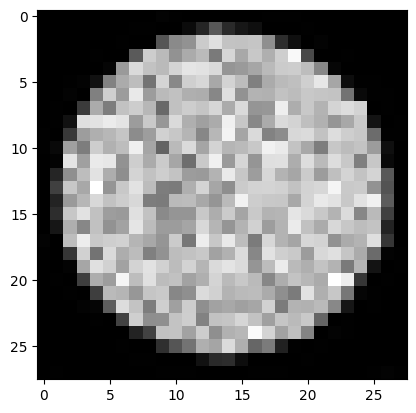

In [13]:
# Bilder ins richtige Format bringen.
def bild_formatieren(pfad):
    img = Image.open(pfad).convert('L') # L macht es zu grauscale
    img =img.resize((28,28), Image.Resampling.LANCZOS)
    imageArray = np.array(img)

    print(f"Bild erfolgreich geladen und in die Form {imageArray.shape} gebracht.")
    return imageArray


plt.imshow(bild_formatieren("FarbenblindZahl.jpg"), cmap="Greys", interpolation="None")

In [ ]:
# funktioniert noch nicht
modelname = "model.pkl"
img = bild_formatieren("FarbenblindZahl.jpg")
input_tensor = torch.from_numpy(img).float() / 255.0
input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)
input_tensor = input_tensor.flatten(start_dim=1)

with open(modelname, "rb") as f:
    loaded_model = pickle.load(f)

loaded_model.forward_pass(input_tensor)